In [1]:
import pickle
import time

from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

from model import WFModelConfig, WFDesignMatrix, WFFitResult
from galsim.zernike import zernikeRotMatrix
from batoid.plotUtils import zernikePyramid

In [2]:
# Assemble catalog
t0 = time.time()
cat = Table()

thx = []
thy = []
visit = []
ccd = []
ccdx = []
ccdy = []
rotation = []
zs = []
zrots = []
good = []

for i in range(24):
# for i in range(4):
    with open(f"rotation_study/visit_{i}.pkl", 'rb') as fd:
        data = pickle.load(fd)
        thx.append(data['thxs'])
        thy.append(data['thys'])
        visit.extend([i]*len(data['thxs']))
        ccd.append(data['ccds'])
        ccdx.append(data['ccdxs'])
        ccdy.append(data['ccdys'])
        rotation.extend([data['rotation']]*len(data['thxs']))
        zs.append(data['zs'])
        good.extend(data['good'])
        R = zernikeRotMatrix(28, data['rotation'])
        zrots.append(np.dot(R, data['zs'].T).T)
cat['thx'] = np.concatenate(thx)
cat['thy'] = np.concatenate(thy)
cat['visit'] = np.array(visit)
cat['ccd'] = np.concatenate(ccd)
cat['ccdx'] = np.concatenate(ccdx)
cat['ccdy'] = np.concatenate(ccdy)
cat['rotation'] = np.array(rotation)
cat['z'] = np.concatenate(zs)
cat['zrot'] = np.concatenate(zrots)
for j in range(1, 29):
    cat[f'z{j}'] = cat['zrot'][:,j]
cat = cat[good]
cat.sort(['visit', 'ccd'])
t1 = time.time()
print(f"{t1-t0} seconds")

0.9385018348693848 seconds


In [20]:
config = WFModelConfig(
    tel='lsst', 
    visit='through20', 
    ccd='tilt',    
    ccdDZs=[(4,4), (5,4), (6,4)],
    zeroCCDSum=True, 
    zeroVisitSum=True
)
print(config.ccdDZs)

[DZ(k=1, j=4), DZ(k=2, j=4), DZ(k=3, j=4), DZ(k=6, j=4), DZ(k=5, j=4), DZ(k=4, j=4)]


In [21]:
t0 = time.time()
design = WFDesignMatrix(config, cat, 4, focalRadius=1.75, ccdRadius=np.hypot(2000, 2036)*10e-6)
t1 = time.time()
print(f"{t1-t0} seconds")

7.291421175003052 seconds


In [22]:
t0 = time.time()
_ = design.design
t1 = time.time()
print(f"{t1-t0} seconds")

13.453718662261963 seconds


In [23]:
t0 = time.time()
result, res, rank, s = np.linalg.lstsq(design.design, design.constraints, rcond=None)
t1 = time.time()
print(f"{t1-t0} seconds")

11.855957984924316 seconds


In [7]:
for name, val in zip(design.columns, result):
    print(name, val)

('tel', DZ(k=1, j=4)) -0.004840123838001104
('tel', DZ(k=4, j=4)) 0.001257193758248478
('tel', DZ(k=11, j=4)) -0.025102612779119904
('visit', (0, DZ(k=1, j=4))) 0.03428212527791381
('visit', (0, DZ(k=2, j=4))) 0.05273859455888745
('visit', (0, DZ(k=3, j=4))) -0.0631407193038738
('visit', (1, DZ(k=1, j=4))) -0.0031125746224065637
('visit', (1, DZ(k=2, j=4))) 0.09041917607166312
('visit', (1, DZ(k=3, j=4))) -0.03601933781607335
('visit', (2, DZ(k=1, j=4))) -0.1234503659699618
('visit', (2, DZ(k=2, j=4))) 0.04613465565294281
('visit', (2, DZ(k=3, j=4))) -0.0881860202187316
('visit', (3, DZ(k=1, j=4))) -0.039417826967754296
('visit', (3, DZ(k=2, j=4))) 0.05899555236632669
('visit', (3, DZ(k=3, j=4))) 0.0057174239209245685
('visit', (4, DZ(k=1, j=4))) -0.011170835333613169
('visit', (4, DZ(k=2, j=4))) 0.09293544298285865
('visit', (4, DZ(k=3, j=4))) 0.04081281055109898
('visit', (5, DZ(k=1, j=4))) 0.10087249697535437
('visit', (5, DZ(k=2, j=4))) -0.008020722275683168
('visit', (5, DZ(k=3, j

In [24]:
fitResult = WFFitResult(config, design, result) 

In [25]:
telWF = fitResult.getTelWF(cat)
visitWF = fitResult.getVisitWF(cat)
ccdWF = fitResult.getCCDWF(cat)

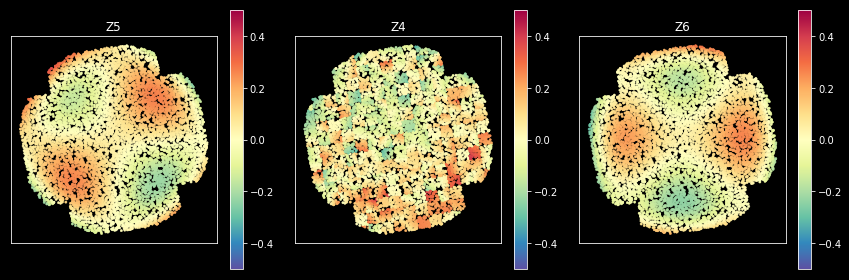

In [26]:
w = cat['visit'] == 0
fig = plt.figure(figsize=(12, 4))
zernikePyramid(cat['thx'][w], cat['thy'][w], cat['zrot'][w,4:7].T, s=5, fig=fig)
plt.show()

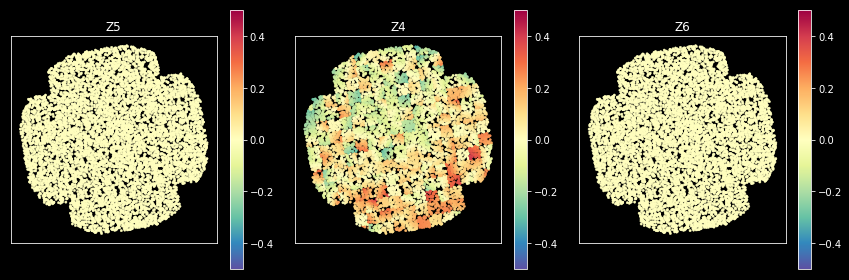

In [27]:
w = cat['visit'] == 0
fig = plt.figure(figsize=(12, 4))
zernikePyramid(
    cat['thx'][w], cat['thy'][w], 
    telWF[w,4:7].T+visitWF[w,4:7].T+ccdWF[w,4:7].T, 
    s=5, fig=fig
)
plt.show()

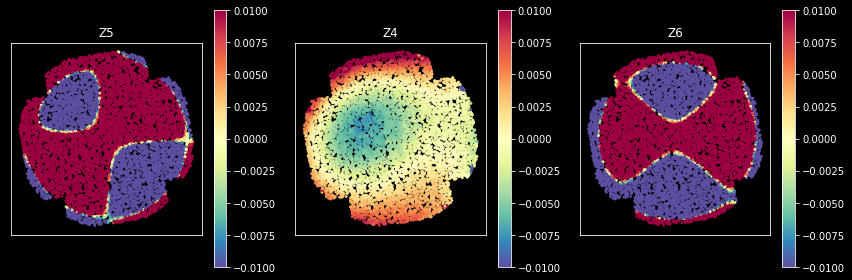

In [28]:
w = cat['visit'] == 0
fig = plt.figure(figsize=(12, 4))
zernikePyramid(
    cat['thx'][w], cat['thy'][w], 
    cat['zrot'][w,4:7].T - (telWF[w,4:7].T+visitWF[w,4:7].T+ccdWF[w,4:7].T),
    s=5, fig=fig, vmin=-0.02, vmax=0.02
)
plt.show()

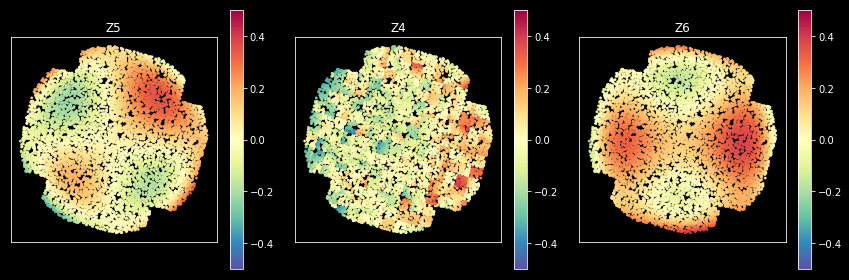

In [29]:
w = cat['visit'] == 1
fig = plt.figure(figsize=(12, 4))
zernikePyramid(cat['thx'][w], cat['thy'][w], cat['zrot'][w,4:7].T, s=5, fig=fig)
plt.show()

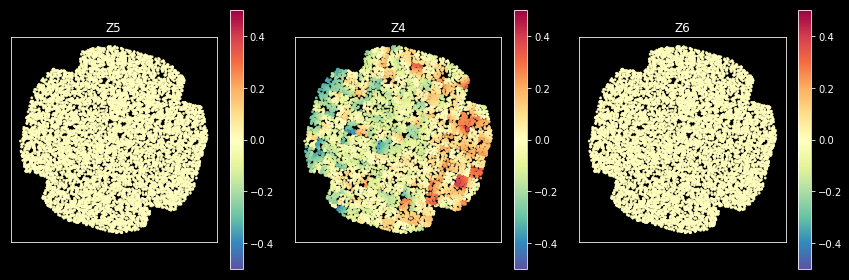

In [30]:
w = cat['visit'] == 1
fig = plt.figure(figsize=(12, 4))
zernikePyramid(
    cat['thx'][w], cat['thy'][w], 
    telWF[w,4:7].T+visitWF[w,4:7].T+ccdWF[w,4:7].T,
    s=5, fig=fig
)
plt.show()

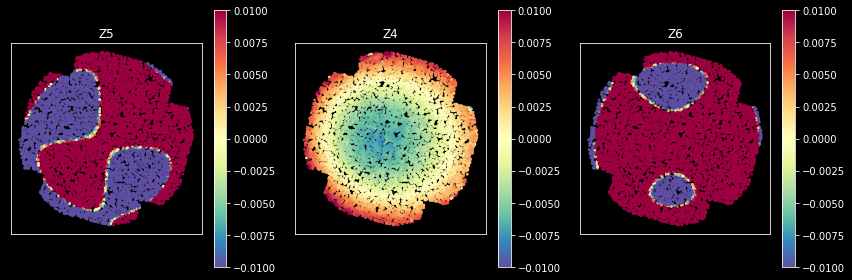

In [31]:
w = cat['visit'] == 1
fig = plt.figure(figsize=(12, 4))
zernikePyramid(
    cat['thx'][w], cat['thy'][w], 
    cat['zrot'][w,4:7].T - (telWF[w,4:7].T+visitWF[w,4:7].T+ccdWF[w,4:7].T),
    s=5, fig=fig, vmin=-0.02, vmax=0.02
)
plt.show()